### Introduction to Models
#### "How" Models

To investigate "How" models will build simple neuronal models and compare their spiking response to real data:
- Write code to simulate a simple “leaky integrate-and-fire” neuron model
- Make the model more complicated — but also more realistic — by adding more physiologically-inspired details

#### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [8]:
# @title Plotting Functions

def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()

  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None:
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None

  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)
def plot_neuron_stats(v, spike_times):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

  # membrane voltage trace
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='red')
    
      # ISI distribution
  if len(spike_times)>1:
    isi = np.diff(spike_times)
    n_bins = np.arange(isi.min(), isi.max() + 2) - .5
    counts, bins = np.histogram(isi, n_bins)
    vlines = []
    if len(isi) > 0:
      vlines = [np.mean(isi)]
    xmax = max(20, int(bins[-1])+5)
    histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
      'xlabel': 'Inter-spike interval',
      'ylabel': 'Number of intervals',
      'xlim': [0, xmax]
    })
  else:
    ax2.set(xlabel='Inter-spike interval',
           ylabel='Number of intervals')
  plt.show()

#### Linear Integrate-and-Fire Neuron
_How does a Neuron spike?_

Neuron charges and discharges electric field across its cell membrane. State of this field is the membrane potential. Potential rises when neuron is excited, when reaches a threshold a spike occurs. Potential resets and must rise to threshold again before spike can reoccur.

Simple model of neuron behaviour is LIFN model. Neuron increases membrane potential $V_{m}$ over time in response to excitatory input current $I$ scaled by some factor $\alpha$:
$$
dV_{m}=\alpha I
$$

$V_{m}$ reaches a threshold and spike occurs, $V_{m}$ resets and process continues.

Here, starting and threshold potentials are $0$ and $1$. If input current is constant then $dV_{m}$ increases at a contant rate. 

Note membrane potential is defined as a scalar. However, a biological neuron's membrane potential will not be exactly constant at all points on its cell membrane at a given time. We could capture this variation with a more complex model (e.g. with more numbers). Do we need to?

Proposed model is a 1D simplification, details can be added to preserve complex structure and dynamics of a real neuron.  If we were interested in small or local changes in the membrane potential, our 1D simplification could be a problem. However, we'll assume an idealized "point" neuron model for our current purpose.

#### Spiking inputs
Simplified model but still need to consider form of input $I$. How to specify firing behaviour of presynaptic neuron(s) providing inputs to the model?

Input current is generally not constant, can describe this variation with a distribution.

We’ll assume the input current $I$ over a timestep is due to equal contributions from a non-negative integer number of input spikes arriving in that timestep. Our model neuron might integrate currents from 3 input spikes in one timestep, and 7 spikes in the next timestep.

Also assume distribution has a mean rate (number of spikes received per timestep). Assume spiking events of input neuron(s) are independent in time. 

Will use the Poission distribution given these assumptions.

#### Compute $dV_{m}$

Compute change in voltage per timestep of LIFN model. Using a pred made <font color=green>plot_neuron_stats</font> function to display the data.

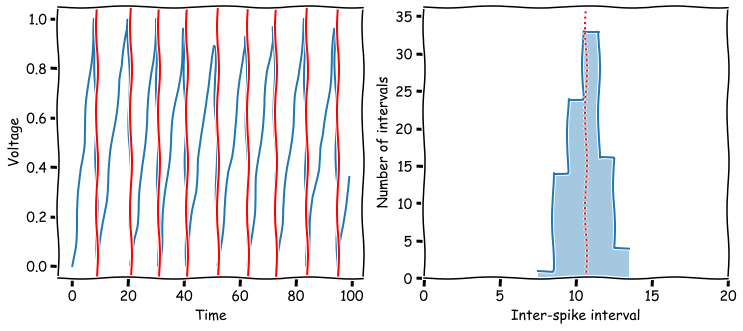

In [9]:
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes

  """
  # Precompute Poisson samples for speed
  exc = stats.poisson(rate).rvs(n_steps)

  # Initialize voltage and spike storage
  v = np.zeros(n_steps)
  spike_times = []

  # Loop over steps
  for i in range(1, n_steps):

    # Update v
    dv = alpha*exc[i]
    v[i] = v[i-1] + dv

    # If spike happens, reset voltage and record
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron()

# Visualize
with plt.xkcd():
  plot_neuron_stats(v, spike_times)

#### Inhibitory Signals

Previously only considered excitatory behaviour. Only way membrane potential could decrease was upon a spike event. There are factors that can drive $V_{m}$ down such as the natural tendency for a neuron to return to some resting potential:
$$
dV_{m}=-\beta V_{m}+\alpha I
$$
where $V_{m}$ is current membrane potential and $\beta$ is some leakage factor.This is a basic form of the LIFN model.

As well as excitatory presynaptic neurons there are inhibitory presynaptic neurons. Can also be modelled with another poisson random variable.

#### Compute $dV_{m}$ with inhibitory signals

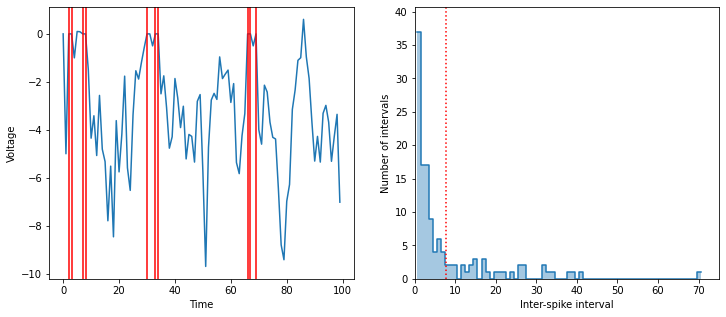

In [10]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """

  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []


  for i in range(1, n_steps):

    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron_inh()

# Visualize
plot_neuron_stats(v, spike_times)

Integrate and fire with inhibition and excitation, we have spikes and dips in the data, much more realistic model. Histogram looks like an exponential. All neurons have exponential inter spike interval distribution. (1st order). Output of neurons should also look like the input.

Over short integration window, certain probability of hitting threshold (more noise higher p). all integration windows are independent. Exponential because fixed probability of ending.

__How Models__

- Start with how biology solves a problem
- Hypothesize a mechanism
- Simulate mechanism
- Check coinciding with measurements

Want to describe what we measure in terms of a logical mechanism.

#### Why Neurons Spike
- Neurons store energy in an electric field across its cell membrane. Controls distribution of ions (charge) on either side of membrane.
- Energy rapdily discharged to generate a spike when membrane potential crosses a threshold. 
- Membrane potential driven away or towards threshold depeding on inputs from excitatory or inhibitory neurons.
- Membrane potenetial tends to revert to resting potential, due to leakage of ions.

Basis for leaky integrate-and-fire neuron model:
- The storage of energy by maintaining a field potential across an insulating membrane can be modeled by a capacitor. 
- The leakage of charge across the membrane can be modeled by a resistor.

Full equation for LIF neuron is:

$$
C_{m}\frac{dV_{m}}{dt}=\frac{(V_{m}-V_{rest})}{R_{m}}+I
$$

Where $C_{m}$ is membrane capacitance, $R_{m}$ is membrane resistance, $V_{rest}$ is resting potential and $I$ is some input current (from neurons or electrodes etc).